# Homework 1

**Name**: **Nima Amir Dastmalchi**

**UID**: **505320372**

In [118]:
# Download a processed version of the data
!wget https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt

--2022-10-08 03:02:39--  https://web.cs.ucla.edu/~zshi/files/CS146/mushroom.txt
Resolving web.cs.ucla.edu (web.cs.ucla.edu)... 131.179.128.29
Connecting to web.cs.ucla.edu (web.cs.ucla.edu)|131.179.128.29|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1264848 (1.2M) [text/plain]
Saving to: ‘mushroom.txt.3’

mushroom.txt.3      100%[===================>]   1.21M  3.01MB/s    in 0.4s    

2022-10-08 03:02:39 (3.01 MB/s) - ‘mushroom.txt.3’ saved [1264848/1264848]



In [119]:
# Use only the provided packages
import sys
import math
import csv
import pandas
import os
import numpy as np
from collections import Counter
from dataclasses import dataclass

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

mpl.lines.width = 2
mpl.axes.labelsize = 14

In [120]:
class Classifier(object) :
    """
    Classifier interface.
    """

    def fit(self, X, y):
        raise NotImplementedError()

    def predict(self, X):
        raise NotImplementedError()


class MajorityVoteClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that always predicts the majority class.

        Attributes
        --------------------
            prediction_ -- majority class
        """
        self.prediction_ = None

    def fit(self, X, y) :
        """
        Build a majority vote classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """
        majority_val = Counter(y).most_common(1)[0][0]
        self.prediction_ = majority_val
        return self

    def predict(self, X) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.prediction_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")

        n,d = X.shape
        y = [self.prediction_] * n
        return y

In [121]:
class RandomClassifier(Classifier) :

    def __init__(self) :
        """
        A classifier that predicts according to the distribution of the classes.

        Attributes
        --------------------
            probabilities_ -- class distribution dict (key = class, val = probability of class)
        """
        self.probabilities_ = None

    def fit(self, X, y) :
        """
        Build a random classifier from the training set (X, y).

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            y    -- numpy array of shape (n,), target classes

        Returns
        --------------------
            self -- an instance of self
        """

        ### ========== TODO (a): START ========== ###
        # set self.probabilities_ according to the training set
        counter = Counter(y)

        # divide each value in the counter dict by the number of instances
        self.probabilities_ = {key: value / len(y)
                                 for key, value in counter.items()}
                                
        ### ========== TODO : END ========== ###

        return self

    def predict(self, X, seed=1234) :
        """
        Predict class values.

        Parameters
        --------------------
            X    -- numpy array of shape (n,d), samples
            seed -- integer, random seed

        Returns
        --------------------
            y    -- numpy array of shape (n,), predicted classes
        """
        if self.probabilities_ is None :
            raise Exception("Classifier not initialized. Perform a fit first.")
        np.random.seed(seed)

        ### ========== TODO (a): START ========== ###
        # predict the class for each test example
        # hint: use np.random.choice (be careful of the parameters)
        n,d = X.shape
        y = []
        for _ in range(n):
          # choose a key from self.probabilities_. Each key will have a
          # probability of self.probabilities_[key] to be selected
          randLabel = np.random.choice(list(self.probabilities_.keys()),
                                       p=list(self.probabilities_.values()))
          y.append(randLabel)

        ### ========== TODO : END ========== ###
        return y


In [122]:
def plot_histograms(X, y, Xnames, yname) :
    n,d = X.shape  # n = number of examples, d =  number of features
    fig = plt.figure(figsize=(20,20))
    ncol = 3
    nrow = d // ncol + 1
    for i in range(d) :
        fig.add_subplot (nrow,ncol,i+1)
        data, bins, align, labels = plot_histogram(X[:,i], y, Xname=Xnames[i], yname=yname, show = False)
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xnames[i])
        plt.ylabel('Frequency')
        plt.legend()

    plt.savefig ('histograms.pdf')


def plot_histogram(X, y, Xname, yname, show = True) :
    """
    Plots histogram of values in X grouped by y.

    Parameters
    --------------------
        X     -- numpy array of shape (n,d), feature values
        y     -- numpy array of shape (n,), target classes
        Xname -- string, name of feature
        yname -- string, name of target
    """

    # set up data for plotting
    targets = sorted(set(y))
    data = []; labels = []
    for target in targets :
        features = [X[i] for i in range(len(y)) if y[i] == target]
        data.append(features)
        labels.append('%s = %s' % (yname, target))

    # set up histogram bins
    features = set(X)
    nfeatures = len(features)
    test_range = list(range(int(math.floor(min(features))), int(math.ceil(max(features)))+1))
    if nfeatures < 10 and sorted(features) == test_range:
        bins = test_range + [test_range[-1] + 1] # add last bin
        align = 'left'
    else :
        bins = 10
        align = 'mid'

    # plot
    if show == True:
        plt.figure()
        n, bins, patches = plt.hist(data, bins=bins, align=align, alpha=0.5, label=labels)
        plt.xlabel(Xname)
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

    return data, bins, align, labels

In [123]:
def error(clf, X, y, ntrials=1, test_size=0.0) :
    """
    Computes the classifier error over a random split of the data,
    averaged over ntrials runs.

    Parameters
    --------------------
        clf         -- classifier
        X           -- numpy array of shape (n,d), features values
        y           -- numpy array of shape (n,), target classes
        ntrials     -- integer, number of trials

    Returns
    --------------------
        train_error -- float, training error
        test_error  -- float, test error
        f1_score    -- float, test "micro" averaged f1 score
    """

    ### ========== TODO (d): START ========== ###
    # compute cross-validation error using StratifiedShuffleSplit over ntrials
    # hint: use StratifiedShuffleSplit (be careful of the parameters)
    train_error, test_error, f1_score = 0, 0, 0

    sss = StratifiedShuffleSplit(n_splits=ntrials,
                                 test_size=test_size,
                                 random_state=0)
    # iterate through ntrials of split data into train and test sets
    for train_index, test_index in sss.split(X, y):
      # get the current train and test sets
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      # fit on the train data
      clf.fit(X_train, y_train)

      # predict the train data and compute train error
      y_pred_train = clf.predict(X_train)
      cur_train_error = 1 - metrics.accuracy_score(y_train,
                                                   y_pred_train,
                                                   normalize=True)
      train_error += cur_train_error

      # predict the test data and compute test error
      y_pred_test = clf.predict(X_test)
      cur_test_error = 1 - metrics.accuracy_score(y_test,
                                                  y_pred_test,
                                                  normalize=True)
      test_error += cur_test_error

      # compute current f1 score
      f1_score += metrics.f1_score(y_test, y_pred_test, average='micro')

    train_error /= ntrials
    test_error /= ntrials
    f1_score /= ntrials
    ### ========== TODO : END ========== ###
    
    return train_error, test_error, f1_score


In [124]:
# Load the Mushroom dataset

@dataclass
class Dataset:
    """Class for the dataset."""
    X: np.array
    y: np.array
    Xnames: list
    yname: str

def load_data(data_file='mushroom.txt'):
    """Load data and map strings to numbers."""
    data = pandas.read_csv(data_file).to_numpy()
    n = data.shape[0]
    d = data.shape[1] - 1
    # Map strings to numbers
    X = np.zeros((n, d))
    for i in range(d):
        mapping = {name: j for j, name in enumerate(set(data[:, i+1]))}
        for j in range(n):
            X[j, i] = mapping[data[j, i+1]]
    mapping = {'EDIBLE': 1, 'POISONOUS': 0}
    y = np.zeros(n, dtype=np.int32)
    for j in range(n):
        y[j] = mapping[data[j, 0]]
    #0 'cap-shape', 
    #1 'cap-surface', 
    #2 'cap-color', 
    #3 'bruises', 
    #4 'odor',      
    #5 'gill-attachment', 
    #6 'gill-spacing', 
    #7 'gill-size', 
    #8 'gill-color',
    #9 'stalk-shape', 
    #10 'stalk-root', 
    #11 'stalk-surface-above-ring', 
    #12 'stalk-surface-below-ring',
    #13 'stalk-color-above-ring',
    #14 'stalk-color-below-ring',
    #15 'veil-type',
    #16 'veil-color',
    #17 'ring-number',
    #18 'ring-type',
    #19 'spore-print-color',
    #20 'population',
    #21 'habitat',        
    Xnames = [
        'cap-shape', 
        'cap-surface', 
        'cap-color', 
        'bruises', 
        'odor',
        'gill-attachment', 
        'gill-spacing', 
        'gill-size', 
        'gill-color',
        'stalk-shape', 
        'stalk-root', 
        'stalk-surface-above-ring', 
        'stalk-surface-below-ring',
        'stalk-color-above-ring',
        'stalk-color-below-ring',
        'veil-type',
        'veil-color',
        'ring-number',
        'ring-type',
        'spore-print-color',
        'population',
        'habitat',
    ]
    # We only use these 6 features
    features = [0, 2, 8, 10, 15, 17]
    X = np.take(X, features, axis=-1)
    Xnames = [Xnames[i] for i in features]
    return Dataset(X=X, y=y, Xnames=Xnames, yname='edible')

data = load_data()

X = data.X; Xnames = data.Xnames
y = data.y; yname = data.yname
n,d = X.shape  # n = number of examples, d =  number of features

Plotting...


/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


<Figure size 432x288 with 0 Axes>

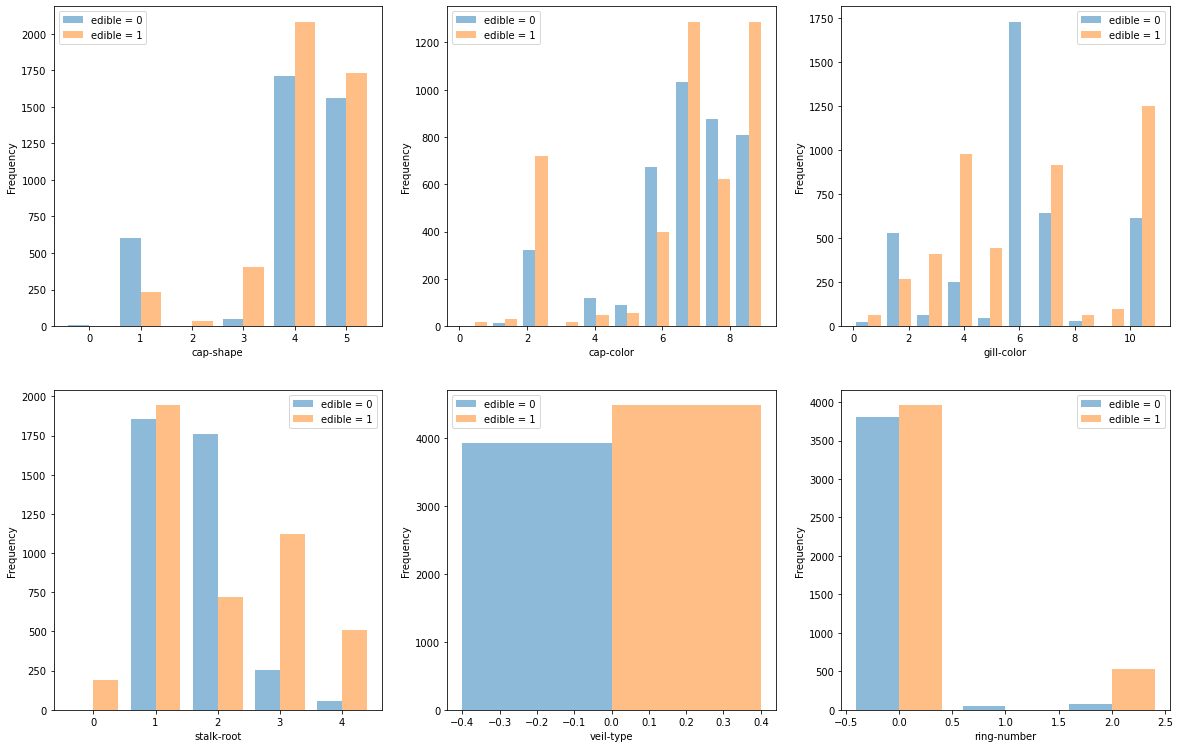

In [125]:
plt.figure()
# Plot histograms of each feature
print('Plotting...')
plot_histograms (X, y, Xnames=Xnames, yname=yname)

In [126]:
# train Majority Vote classifier on data
print('Classifying using Majority Vote...')
clf = MajorityVoteClassifier() # create MajorityVote classifier, which includes all model parameters
clf.fit(X, y)                  # fit training data using the classifier
y_pred = clf.predict(X)        # take the classifier and run it on the training data
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

# output:
# Classifying using Majority Vote...
#	       -- training error: 0.467

Classifying using Majority Vote...
	-- training error: 0.467


In [127]:
### ========== TODO (a): START ========== ###
# evaluate training error of Random classifier
print('Classifying using Random Classifier...')
clf = RandomClassifier()
clf.fit(X, y)
y_pred = clf.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

# output:
# Classifying using Random Classifier...
#        -- training error: 0.506

### ========== TODO : END ========== ###

Classifying using Random Classifier...
	-- training error: 0.506


In [128]:
### ========== TODO (b): START ========== ###
# evaluate training error of Decision Tree classifier
print('Classifying using DecisionTreeClassifier...')
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)
y_pred = clf.predict(X)
train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
print('\t-- training error: %.3f' % train_error)

# output:
# Classifying using DecisionTreeClassifier...
#        -- training error: 0.055

### ========== TODO : END ========== ###

Classifying using DecisionTreeClassifier...
	-- training error: 0.055


In [129]:
### ========== TODO (c): START ========== ###
# evaluate training error of k-Nearest Neighbors classifier
# use k = 3, 11, 19 for n_neighbors
print('Classifying using KNeighborsClassifier...')
for k in [3, 11, 19]:
  clf = KNeighborsClassifier(n_neighbors=k)
  clf.fit(X, y)
  y_pred = clf.predict(X)
  train_error = 1 - metrics.accuracy_score(y, y_pred, normalize=True)
  print('\t-- training error for k=%d: %.3f' % (k, train_error))

# output
# Classifying using KNeighborsClassifier...
#        -- training error for k=3: 0.114
#        -- training error for k=11: 0.130
#        -- training error for k=19: 0.103

### ========== TODO : END ========== ###

Classifying using KNeighborsClassifier...
	-- training error for k=3: 0.114
	-- training error for k=11: 0.130
	-- training error for k=19: 0.103


In [131]:
 ## ========== TODO (d): START ========== ###
# use cross-validation to compute average training and test error of classifiers
print('Investigating various classifiers...')
classifiers = {
    'Majority Vote': MajorityVoteClassifier(),
    'Random Classifier': RandomClassifier(),
    'Decision Tree': DecisionTreeClassifier(criterion='entropy'),
    'K Nearest Neighbors': KNeighborsClassifier(n_neighbors=11)
}

for name, clf in classifiers.items():
  print('\t-- Classifying %s...' % name)
  errors = error(clf, X, y, ntrials=100, test_size=0.15)
  print('\t\t-- Training error: %.3f' % errors[0])
  print('\t\t-- Test error: %.3f' % errors[1])
  print('\t\t-- F1 score: %.3f' % errors[2])

# output:
# Investigating various classifiers...
# 	-- Classifying Majority Vote...
# 		-- Training error: 0.467
# 		-- Test error: 0.467
# 		-- F1 score: 0.533
# 	-- Classifying Random Classifier...
# 		-- Training error: 0.499
# 		-- Test error: 0.500
# 		-- F1 score: 0.500
# 	-- Classifying Decision Tree...
# 		-- Training error: 0.055
# 		-- Test error: 0.056
# 		-- F1 score: 0.944
# 	-- Classifying K Nearest Neighbors...
# 		-- Training error: 0.067
# 		-- Test error: 0.071
# 		-- F1 score: 0.929

### ========== TODO : END ========== ###

Investigating various classifiers...
	-- Classifying Majority Vote...
		-- Training error: 0.467
		-- Test error: 0.467
		-- F1 score: 0.533
	-- Classifying Random Classifier...
		-- Training error: 0.499
		-- Test error: 0.500
		-- F1 score: 0.500
	-- Classifying Decision Tree...
		-- Training error: 0.055
		-- Test error: 0.056
		-- F1 score: 0.944
	-- Classifying K Nearest Neighbors...
		-- Training error: 0.067
		-- Test error: 0.071
		-- F1 score: 0.929


In [116]:
### ========== TODO (e): START ========== ###
# use 5-fold cross-validation to find the best value of k for k-Nearest Neighbors classifier
print('Finding the best k...')

### ========== TODO : END ========== ###

Finding the best k...


In [117]:
### ========== TODO (f): START ========== ###
# investigate decision tree classifier with various depths
print('Investigating depths...')

### ========== TODO : END ========== ###

Investigating depths...
